In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)
    
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)
    
def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

In [3]:
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\abhil\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10 # number of neuros of the fourth hidden layer
noice = 0.5 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2* math.pi/C

In [5]:
r=0.3
r2=0.5
n = int(N/2)
n

250

In [6]:
for i in range(C):  # Here i = 0, 1, 2, ..., C-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
   
    # Generate the N sample points in the $i$th subdomain D_i
   
        
    for ix in range(n * i, n * (i + 1)):
        X[ix] = torch.FloatTensor((
            r*math.sin(theta[j]), r*math.cos(theta[j])
        ))
        y[ix] = i
        j += 1
        
    for ix in range(n * i+750, n * (i + 1)+750):
        X[ix] = torch.FloatTensor((
            r2*math.sin(theta[j]), r2*math.cos(theta[j])
        ))
        y[ix] = i
        j += 1
      

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (1500, 2)
y: (1500,)


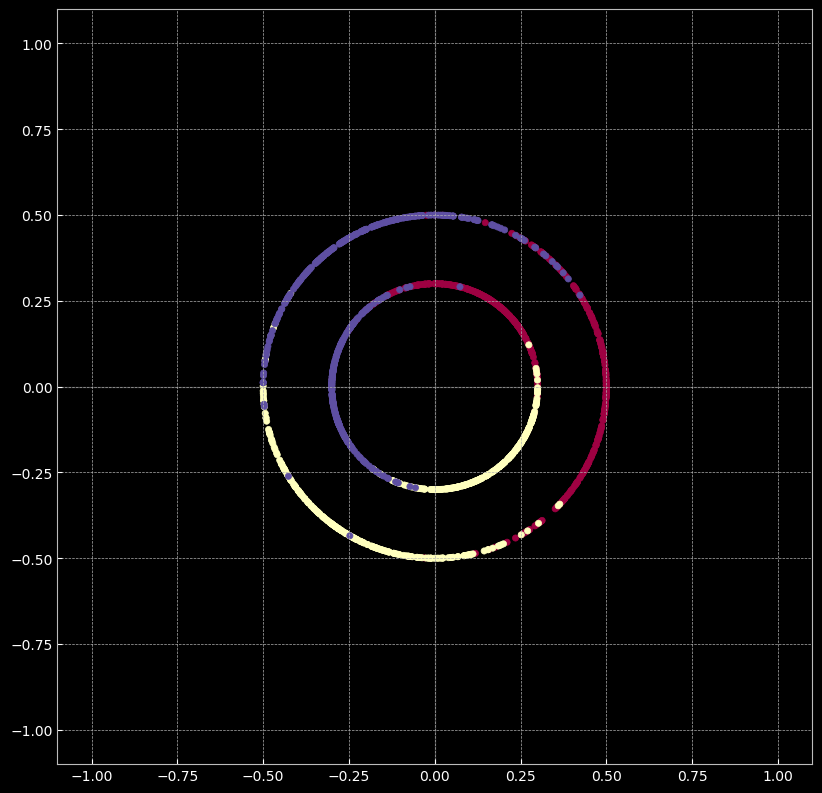

In [7]:
plot_data(X, y)

In [8]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [9]:
# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(
    nn.Linear(D, H1),
    nn.Linear(H1, H2),
    nn.Linear(H2, H3),
    nn.Linear(H3, C)
)
linear_model.to(device) #Convert to CUDA

# nn package has different loss functions.
# We can use the Mean Squared Error Loss Function: 
#     Loss = torch.nn.MSELoss()
#  or use the cross entropy loss function:
#     Loss = torch.nn.CrossEntropyLoss()

#Loss = torch.nn.MSELoss()
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = linear_model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 1.084271, [ACCURACY]: 0.566


# Modified ReLU

In [10]:
class mReLU(nn.Module):
# Define mReLU as a subclass of nn.Module.  Here h is a given parameter.   

    def __init__(self, h=0.5): 
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        y = torch.zeros(x.shape)
        z = torch.where(x>h, x, torch.where(x<-h, y, 1/(4*h)*x*x + 1/2*x + 1/4*h))
        return z

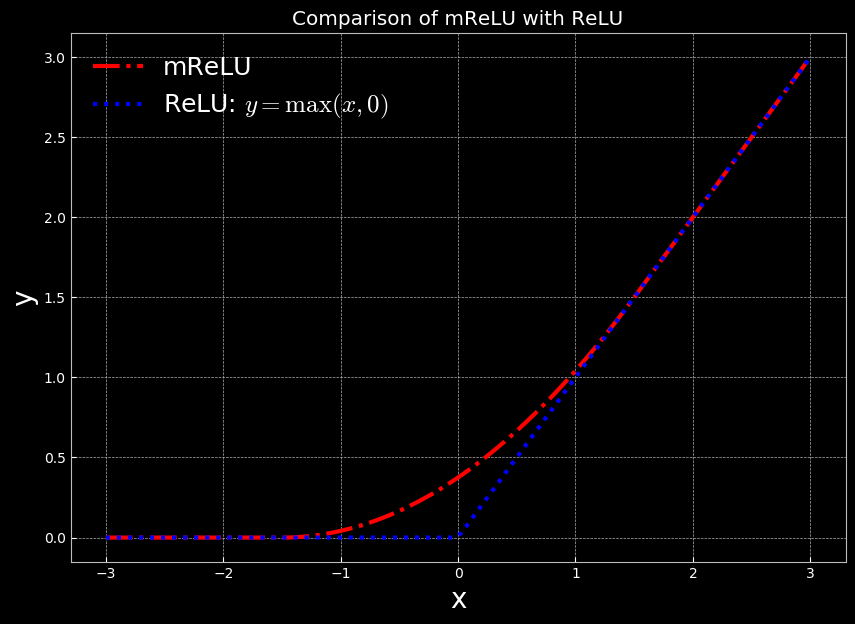

In [11]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mReLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
mrelu = mReLU(1.50)  # with h = 1.5
relu = nn.ReLU()

x = torch.linspace(-3, 3, 100)
# Plot the ReLU function
ax.plot(x, mrelu(x), label = 'mReLU', linestyle='-.', color='r', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle=':', color='b', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)



# mReLU used as activation

In [16]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved.

activation_function = mReLU()
model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function ,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.127187, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.102808, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.061512, [ACCURACY]: 0.537
[EPOCH]: 3, [LOSS]: 1.000548, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 0.910571, [ACCURACY]: 0.597
[EPOCH]: 5, [LOSS]: 0.784457, [ACCURACY]: 0.727
[EPOCH]: 6, [LOSS]: 0.672751, [ACCURACY]: 0.750
[EPOCH]: 7, [LOSS]: 0.594964, [ACCURACY]: 0.797
[EPOCH]: 8, [LOSS]: 0.562720, [ACCURACY]: 0.805
[EPOCH]: 9, [LOSS]: 0.542253, [ACCURACY]: 0.805
[EPOCH]: 10, [LOSS]: 0.538396, [ACCURACY]: 0.811
[EPOCH]: 11, [LOSS]: 0.487001, [ACCURACY]: 0.815
[EPOCH]: 12, [LOSS]: 0.462845, [ACCURACY]: 0.822
[EPOCH]: 13, [LOSS]: 0.459812, [ACCURACY]: 0.819
[EPOCH]: 14, [LOSS]: 0.405798, [ACCURACY]: 0.845
[EPOCH]: 15, [LOSS]: 0.406136, [ACCURACY]: 0.835
[EPOCH]: 16, [LOSS]: 0.414990, [ACCURACY]: 0.816
[EPOCH]: 17, [LOSS]: 0.380924, [ACCURACY]: 0.847
[EPOCH]: 18, [LOSS]: 0.387236, [ACCURACY]: 0.876
[EPOCH]: 19, [LOSS]: 0.366223, [ACCURACY]: 0.875
[EPOCH]: 20, [LOSS]: 0.343619,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): mReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): mReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): mReLU()
  (6): Linear(in_features=10, out_features=3, bias=True)
)


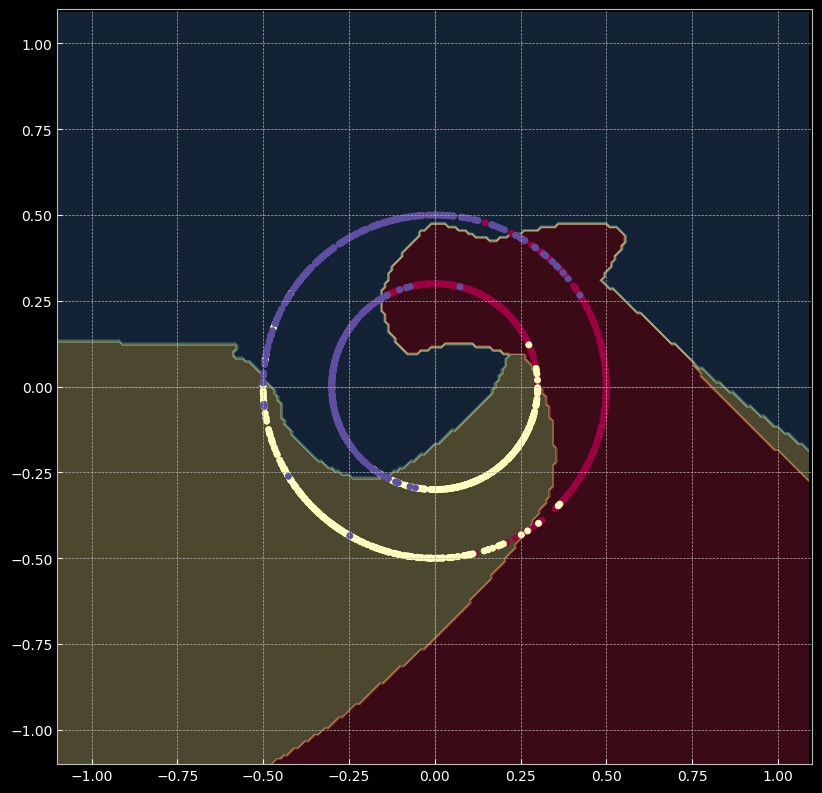

In [17]:
print(model)
plot_model(X, y, model)

# mReLU with NN of three hidden layers

In [19]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model3 = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, H4),
    activation_function,
    nn.Linear(H4, C)
)
model3.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model3(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.113676, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.103860, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.095331, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.057855, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 0.992991, [ACCURACY]: 0.339
[EPOCH]: 5, [LOSS]: 0.986712, [ACCURACY]: 0.592
[EPOCH]: 6, [LOSS]: 0.878307, [ACCURACY]: 0.621
[EPOCH]: 7, [LOSS]: 0.928175, [ACCURACY]: 0.623
[EPOCH]: 8, [LOSS]: 0.849958, [ACCURACY]: 0.635
[EPOCH]: 9, [LOSS]: 0.819232, [ACCURACY]: 0.675
[EPOCH]: 10, [LOSS]: 0.720786, [ACCURACY]: 0.734
[EPOCH]: 11, [LOSS]: 0.665173, [ACCURACY]: 0.764
[EPOCH]: 12, [LOSS]: 0.523834, [ACCURACY]: 0.784
[EPOCH]: 13, [LOSS]: 0.578300, [ACCURACY]: 0.765
[EPOCH]: 14, [LOSS]: 0.522072, [ACCURACY]: 0.813
[EPOCH]: 15, [LOSS]: 0.593556, [ACCURACY]: 0.795
[EPOCH]: 16, [LOSS]: 0.531012, [ACCURACY]: 0.793
[EPOCH]: 17, [LOSS]: 0.522108, [ACCURACY]: 0.799
[EPOCH]: 18, [LOSS]: 0.481438, [ACCURACY]: 0.809
[EPOCH]: 19, [LOSS]: 0.461759, [ACCURACY]: 0.800
[EPOCH]: 20, [LOSS]: 0.483110,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): mReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): mReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): mReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): mReLU()
  (8): Linear(in_features=10, out_features=3, bias=True)
)


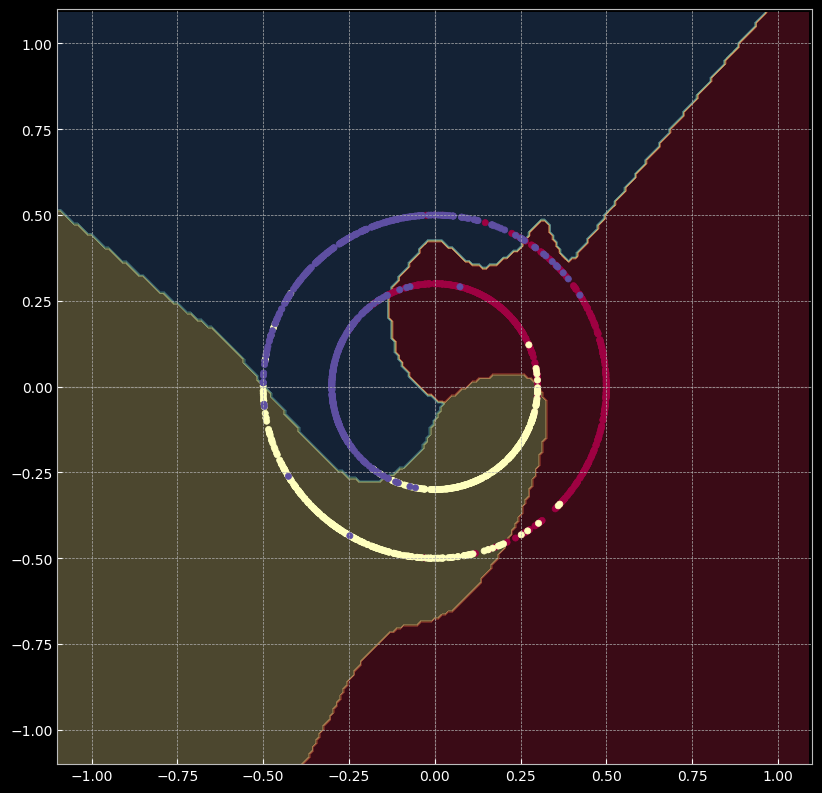

In [20]:
print(model3)
plot_model(X, y, model3)

In [22]:
h1 = 50  # number of neuros of the first hidden layer
h2 = 25  # number of neuros of the second hidden layer
h3 = 25  # number of neuros of the third hidden layer
h4 = 10 # number of neuros of the fourth hidden layer

# mReLU with SGD loss function

In [23]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model6 = nn.Sequential(
    nn.Linear(D, h1),
    activation_function,
    nn.Linear(h1, h2),
    activation_function,
    nn.Linear(h2, h3),
    activation_function,
    nn.Linear(h3, h4),
    activation_function,
    nn.Linear(h4, C)
)
model6.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
optimizer = torch.optim.SGD(model6.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
#optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model6(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.101127, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.100906, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.100703, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.100515, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 1.100342, [ACCURACY]: 0.333
[EPOCH]: 5, [LOSS]: 1.100181, [ACCURACY]: 0.333
[EPOCH]: 6, [LOSS]: 1.100034, [ACCURACY]: 0.333
[EPOCH]: 7, [LOSS]: 1.099895, [ACCURACY]: 0.333
[EPOCH]: 8, [LOSS]: 1.099771, [ACCURACY]: 0.333
[EPOCH]: 9, [LOSS]: 1.099654, [ACCURACY]: 0.333
[EPOCH]: 10, [LOSS]: 1.099548, [ACCURACY]: 0.333
[EPOCH]: 11, [LOSS]: 1.099448, [ACCURACY]: 0.333
[EPOCH]: 12, [LOSS]: 1.099354, [ACCURACY]: 0.333
[EPOCH]: 13, [LOSS]: 1.099267, [ACCURACY]: 0.333
[EPOCH]: 14, [LOSS]: 1.099187, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 1.099113, [ACCURACY]: 0.333
[EPOCH]: 16, [LOSS]: 1.099044, [ACCURACY]: 0.333
[EPOCH]: 17, [LOSS]: 1.098980, [ACCURACY]: 0.333
[EPOCH]: 18, [LOSS]: 1.098922, [ACCURACY]: 0.333
[EPOCH]: 19, [LOSS]: 1.098865, [ACCURACY]: 0.333
[EPOCH]: 20, [LOSS]: 1.098814,